# **Installing new libraries**

In [0]:
!pip install statsforecast
!pip install kneed

You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-928cf1d1-fcbc-4488-8ce0-ebe521cd508c/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-928cf1d1-fcbc-4488-8ce0-ebe521cd508c/bin/python -m pip install --upgrade pip' command.


# **Importing libraries**

In [0]:
import pandas as pd
import numpy as np
import pyspark.pandas as ps
from datetime import datetime
from datetime import date
from datetime import timedelta
from datetime import tzinfo
import pytz
import pyspark.sql.functions as F
import kneed
from kneed import DataGenerator
from kneed import KneeLocator
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
import copy
from scipy import stats
import os
import scipy
import pyspark.sql.functions as fn

from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA


# **Connectivity setup and generic functions**

In [0]:
user_nm='SMAIT05'
snow_enc_pswd_key='SnowEncPswdKey'
snow_enc_pswd_pass='SnowEncPswdPass'
scope_nm='SNF-DOPS-USER-DB-{}-SCP'.format(user_nm)
snow_url='abs_itds_prd.west-us-2.privatelink.snowflakecomputing.com'

from absplatform import snowflake

private_key = snowflake.Snowflake(spark, scope_nm, snow_enc_pswd_key, snow_enc_pswd_pass).get_key()

snfKey  = dbutils.secrets.get(scope=scope_nm, key="SnowEncPswdKey")
snfPass = dbutils.secrets.get(scope=scope_nm, key="SnowEncPswdPass")
snfUser = dbutils.secrets.get(scope=scope_nm, key="SnowUsername")

#ADLS
adls_connection_dict={'adls_server_hostname': 'adb-3055846038102621.1.azuredatabricks.net',
                      'http_path': 'sql/protocolv1/o/3055846038102621/0315-150338-eerie83',
                      'access_token_scope':'scp_itds_devops',
                      'access_token_key' : 'dasc-prod-databricks-01-dbx-key'                        
                          }
#db_work dev/prod paths
pathADLSdev = 'abfs://absitdsdevwussa001@absitdsdevwussa001.dfs.core.windows.net/itds/dev/default/work/'
pathADLSprd = 'abfs://absitdsprodwussa001@absitdsprodwussa001.dfs.core.windows.net/default/work/datascience/'


In [0]:
# EDM connection parameters 
ITDSreadOptions = dict(sfUrl=snow_url,
               sfUser=user_nm,
               pem_private_key=private_key,
               sfDatabase="EDM_FEATURES_PRD",
               sfSchema="SCRATCH_DS",
               sfWarehouse="EDM_DATASCIENCE_WH",
               sfRole="ROLE_USERGROUP_DATASCIENTIST")

# EDM connection parameters 
ITDSwriteOptions = dict(sfUrl=snow_url,
               sfUser=user_nm,
               pem_private_key=private_key,
               sfDatabase="EDM_FEATURES_PRD",
               sfSchema="SCRATCH_DS",
               sfWarehouse="EDM_DATASCIENCE_WH",
               sfRole="ROLE_USERGROUP_DATASCIENTIST")

In [0]:
def read_snowflake(env, sql, role, sys='prd'):
  try:
    if (env == 'edm' and sys == 'prd'):
      swOptions = ITDSreadOptions
    elif(env == 'edm' and sys == 'dev'):
      swOptions = ITDSreadOptionsDev
    else:
      raise Exception('Configuration not found for environment {}.'.format(env))
  except Exception as e:
    raise Exception('Configuration not found for environment {}.'.format(env, e))

  df = spark.read\
    .format("snowflake")\
    .options(**swOptions)\
    .option("query", sql)\
    .load()
  df = df.toDF(*[c.lower() for c in df.columns])
  return df

In [0]:
def write_snowflake(env, sql, table, write_mode):
  try:
    if (env == 'edw'):
      swOptions = EDWwriteOptions
    elif (env == 'edm'):
      swOptions = ITDSwriteOptions
    else:
      raise Exception('Configuration not found for environment {}.'.format(env))
  except Exception as e:
    raise Exception('Configuration not found for environment {}.'.format(env, e))

  (spark.sql(query)
    .write
    #.mode("APPEND")
    .mode(write_mode)
    .format("snowflake")
    .options(**swOptions)
    .option("truncate_table", "on")
    .option("usestagingtable", "off")
    .option("dbtable", table)
    .save()
  ) 
  
  # truncate table option so it doesn't drop DB rights to roles  
  # df_Store_Rog_1.write.format(snowflake_source_name).options(**sfOptions).option("truncate_table", "on").option("usestagingtable", "off").option("dbtable", "CLOG_IN_STORE").mode("overwrite").save()
  
  return

In [0]:
def ecdf(a):
    x, counts = np.unique(a, return_counts=True)
    cusum = np.cumsum(counts)
    return x, cusum / cusum[-1]
    
def plot_ecdf(a):
    x, y = ecdf(a)
    x = np.insert(x, 0, x[0])
    y = np.insert(y, 0, 0.)
    plt.plot(x, y, drawstyle='steps-post')
    plt.grid(True)
    plt.savefig('ecdf.png')

# **Read database table**

In [0]:
'''
unique_id is the combination of 2 digit division and 2 digit smic group code. 
statsforeacst algorithm expects the columns unique_id, ds and y where ds is the timestamp column and
y is the fact data which needs to be foreacsted.
ds column is the month end date.
y denotes total units sold at div-grp-mth level.
'''
sql_stmt = """SELECT division_id || LPAD(smic_group_cd, 2, '0')                                                          AS unique_id
                   , LAST_DAY(CAST((SUBSTR(txn_cal_yr_mth,1,4) || '-' || SUBSTR(txn_cal_yr_mth,5,2) || '-01') AS DATE))  AS ds
                   , total_item_qty                                                                                      AS y 
              FROM   edm_bizops_prd.data_science.div_grp_cal_yr_mth_agg_3
           """.replace("\n", " ").replace("\t"," ")
df = read_snowflake('edm', sql_stmt, 'regular' ,'prd')
pd_df = df.toPandas()
pd_df["ds"]=pd.to_datetime(pd_df["ds"])
df.show()

/databricks/spark/python/pyspark/sql/pandas/utils.py:91: UserWarning: The conversion of DecimalType columns is inefficient and may take a long time. Column names: [y] If those columns are not necessary, you may consider dropping them or converting to primitive types before the conversion.
  warnings.warn(
+---------+----------+-------+
|unique_id|        ds|      y|
+---------+----------+-------+
|     1736|2020-03-31|8253776|
|     1703|2020-03-31|6854446|
|     1708|2020-03-31|5243984|
|     1709|2020-03-31|4739722|
|     1748|2020-03-31|4382907|
|     1725|2020-03-31|3995354|
|     1737|2020-03-31|3834457|
|     1738|2020-03-31|3528978|
|     1702|2020-03-31|2981518|
|     1701|2020-03-31|2909391|
|     1721|2020-03-31|2897682|
|     1711|2020-03-31|2715802|
|     1728|2020-03-31|2525533|
|     1729|2020-03-31|2408716|
|     1730|2020-03-31|2371630|
|     1742|2020-03-31|2053756|
|     1724|2020-03-31|1893625|
|     1747|2020-03-31|1824174|
|     1732|2020-03-31|1692442|
|     1705|

In [0]:
pd_df_latest_mth = pd_df[pd_df.ds == pd_df['ds'].max()]
pd_df_latest_mth['divison_id'] = pd_df_latest_mth['unique_id'].apply(lambda x : x[:2])
pd_df_latest_mth.sort_values(by=['divison_id','y'],ascending=[True, False])

<command-1236937830464536>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,unique_id,ds,y,divison_id
17434,0536,2023-03-31,3288906,05
17435,0508,2023-03-31,2161882,05
17436,0503,2023-03-31,2111822,05
17437,0509,2023-03-31,1910716,05
17438,0537,2023-03-31,1545401,05
...,...,...,...,...
18594,3477,2023-03-31,23469,34
18595,3461,2023-03-31,17291,34
18596,3480,2023-03-31,17081,34
18597,3469,2023-03-31,7004,34


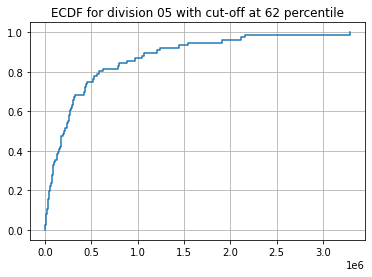

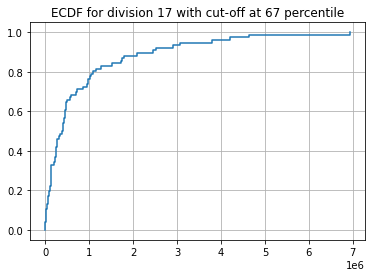

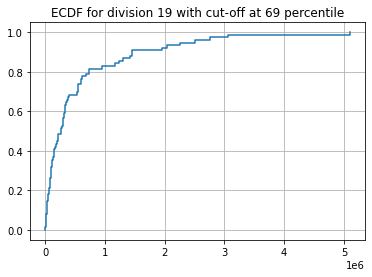

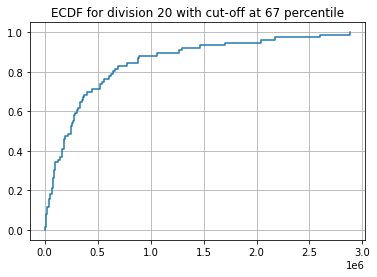

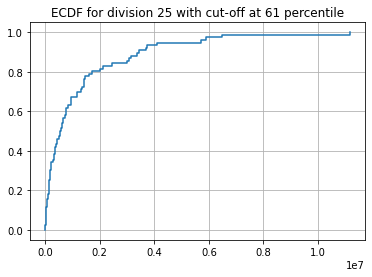

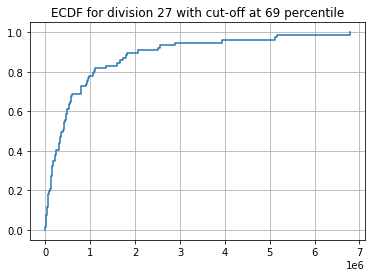

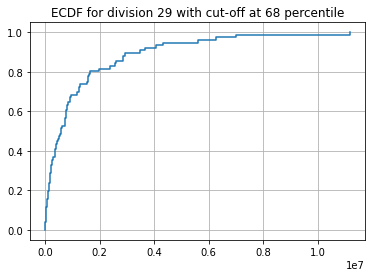

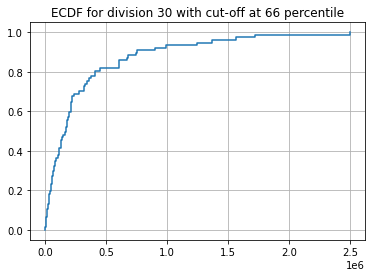

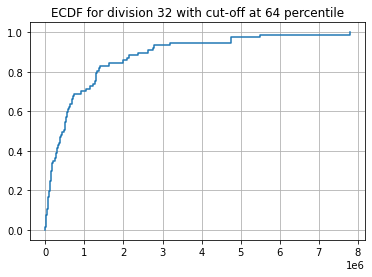

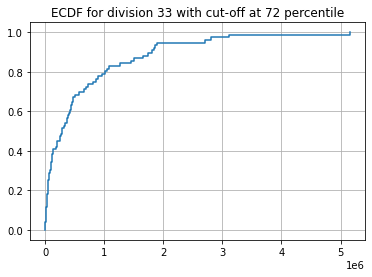

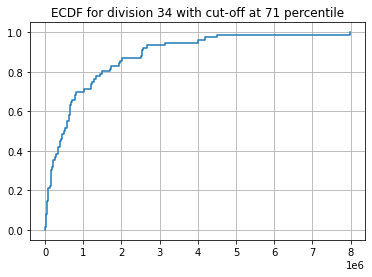

In [0]:
division_id_list = pd_df_latest_mth['divison_id'].drop_duplicates().tolist()
for div in sorted(division_id_list):
    x = pd_df_latest_mth[(pd_df_latest_mth.divison_id == div) & (pd_df_latest_mth.y > 0)]['y'] # generate samples from normal distribution (discrete data)
    y1 = sorted([int(i) for i in x])
    x1 = range(1, len(y1)+1)
    kn = KneeLocator(x1, y1, curve='convex', direction='increasing')
    plot_ecdf(x)
    plt.title(f"ECDF for division {div} with cut-off at {kn.knee} percentile")
    plt.show(block = False)

# **Forecasting**

**Automatic forecasting models(AutoARIMA, AutoETS, AutoCES and AutoTHETA)** models search for the best parameters and select the best possible model for a series of time series. These tools are useful for large collections of univariate time series.

**ARIMA family models(ARIMA and AutoRegressive)** uses existing autocorrelations in the time series and can generate Point Forecast, Probabilistic Forecast,	Insample fitted values and Probabilistic fitted values.

**Theta family models(Theta, OptimizedTheta, DynamicTheta, DynamicOptimizedTheta)** fit two theta lines to a deseasonalized time series, using different techniques to obtain and combine the two theta lines to produce the final forecasts and can generate Point Forecast, Probabilistic Forecast,	Insample fitted values and Probabilistic fitted values.

**Multiple seasonalities model(MSTL)** is suited for signals with more than one clear seasonality. It is useful for low-frequency data like electricity and logs. It can generate Point Forecast, Probabilistic Forecast,	Insample fitted values and Probabilistic fitted values.

**GARCH Models(ARCH and GARCH)** are suited for modeling time series that exhibit non-constant volatility over time. The ARCH(Autoregressive conditional heteroskedasticity) model is a particular case of GARCH. They can generate Point Forecast, Probabilistic Forecast, Insample fitted values and Probabilistic fitted values.

**Baseline Models(HistoricAverage, Naive, RandomWalkWithDrift, SeasonalNaive, WindowAverage, SeasonalWindowAverage)** are the classical models for establishing baseline and HistoricAverage, Naive, RandomWalkWithDrift, SeasonalNaive, SeasonalWindowAverage models generate Point Forecast, Probabilistic Forecast, Insample fitted values and Probabilistic fitted values and WindowAverage, SeasonalWindowAverage can generate only the point foreacst.

**Exponential smoothing models(SimpleExponentialSmoothing, SimpleExponentialSmoothingOptimized, SeasonalExponentialSmoothing, SeasonalExponentialSmoothingOptimized, Holt, HoltWinters)** use a weighted average of all past observations where the weights decrease exponentially into the past. Suitable for data with clear trend and/or seasonality. SimpleExponential family for data with no clear trend or seasonality. Holt, HoltWinters can generate Point Forecast, Probabilistic Forecast, Insample fitted values and Probabilistic fitted values. Other exponential models can only generate the point forecast.

**Sparse or intermittent(ADIDA, CrostonClassic, CrostonOptimized, CrostonSBA, IMAPA, TSB) models** are suited for series with very few non-zero observations and can generate point observations.

In [0]:
"""
Automatically selects the best ARIMA (AutoRegressive Integrated Moving Average) model using an information criterion. 
Default is Akaike Information Criterion (AICc).
"""
sf_autoarima = StatsForecast(
    models = [AutoARIMA(season_length = 12)],
    freq = 'M'
)
sf_autoarima.fit(pd_df)

/local_disk0/.ephemeral_nfs/envs/pythonEnv-928cf1d1-fcbc-4488-8ce0-ebe521cd508c/lib/python3.9/site-packages/statsforecast/arima.py:1923: UserWarning:

Having 3 or more differencing operations is not recommended. Please consider reducing the total number of differences.

Out[19]: StatsForecast(models=[AutoARIMA])

In [0]:
autoarima_forecast_df = sf_autoarima.predict(h=12, level=[90]) 

autoarima_forecast_df.tail()

,ds,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90
unique_id,,,,
3480,2023-11-30,37500.093750,13985.230469,61014.957031
3480,2023-12-31,33250.308594,9735.380859,56765.238281
3480,2024-01-31,19111.281250,-4403.664062,42626.226562
3480,2024-02-29,35695.699219,12180.751953,59210.648438
3480,2024-03-31,17080.378906,-6434.570312,40595.328125


In [0]:
autoarima_forecast_df.loc['0534']

,ds,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90
unique_id,,,,
0534,2023-04-30,44002.574219,30903.884766,57101.261719
0534,2023-05-31,57443.292969,42207.632812,72678.953125
0534,2023-06-30,60049.140625,44127.660156,75970.617188
0534,2023-07-31,73351.203125,57194.644531,89507.765625
0534,2023-08-31,57599.699219,41360.988281,73838.406250
0534,2023-09-30,59190.050781,42922.449219,75457.648438
0534,2023-10-31,54951.269531,38673.484375,71229.054688
0534,2023-11-30,59191.972656,42910.593750,75473.351562
0534,2023-12-31,69743.101562,53460.457031,86025.750000


In [0]:
pd_df[pd_df.unique_id == '0534'].sort_values(by=['ds'], ascending=False)

,unique_id,ds,y
17495,0534,2023-03-31,48516
3873,0534,2023-02-28,50443
15468,0534,2023-01-31,61699
2003,0534,2022-12-31,69815
8696,0534,2022-11-30,59313
23171,0534,2022-10-31,55155
13834,0534,2022-09-30,59533
24958,0534,2022-08-31,58177
22313,0534,2022-07-31,74323
18659,0534,2022-06-30,61685


In [0]:
sf.plot(pd_df[pd_df.unique_id == '0534'].sort_values(by=['ds']), autoarima_forecast_df.loc['0534'], level=[90])

In [0]:
sf.plot(pd_df[pd_df.unique_id == '1934'].sort_values(by=['ds']), autoarima_forecast_df.loc['1934'], level=[90])